# Applies Deep Learning to ePodium dataset for prediction of Dyslexia.

#### Import Packages

In [1]:
import mne
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import ipywidgets

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Precision, BinaryAccuracy, Recall
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from functions import epodium, epodium_deep_learning, display_helper
from models.dnn import fully_connected_model
from models import transformer

import local_paths

2022-09-06 20:43:03.429866: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-06 20:43:03.429906: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


#### Choose which processed data to use

In [2]:
processing_method_widget = ipywidgets.RadioButtons(options=['autoreject', 'ransac'], 
                                                   value='autoreject', 
                                                   description='processing:')
display(processing_method_widget)

RadioButtons(description='processing:', options=('autoreject', 'ransac'), value='autoreject')

<br>

## Preparing data iterator (Sequence) as input to the deep learning models.
https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence

#### Split processed epochs* into train and test sequence.

*In the context of electroencephalography (EEG), *epochs* are EEG segments in which an event occurs. During processing, the epochs are chosen to be 1 second in which the event occurs at 0.2s. In the context of deep learning, *epochs* are iterations over the entire training dataset.

In [49]:
if(processing_method_widget.value == "autoreject"):
    path_processed = local_paths.ePod_processed_autoreject
if(processing_method_widget.value == "ransac"):
    path_processed = local_paths.ePod_processed_ransac

train, test = epodium_deep_learning.split_train_test_datasets(path_processed)
train_sequence = epodium_deep_learning.EvokedDataIterator(train, path_processed)
test_sequence = epodium_deep_learning.EvokedDataIterator(test, path_processed)

Analyzed: 228, bad: 42
186 files have enough epochs for analysis.
The dataset is split up into 138 train and 48 test experiments


#### Visualise data instance

In [50]:
x, y = train_sequence.__getitem__(0)
print(f"The shape of one data instance is {x[0].shape}")

The shape of one data instance is (32, 512)


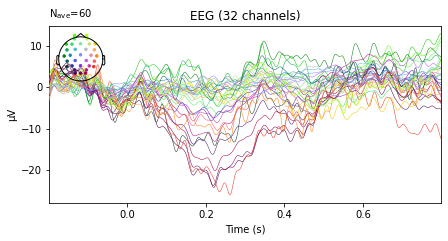

0: female, 1: risk, 0: standard


In [22]:
index = 50 # 0 to 63

info = mne.create_info(epodium.channel_names, 512, ch_types='eeg')
evoked = mne.EvokedArray(x[index], info, tmin=-0.2, nave=60)
montage = mne.channels.make_standard_montage('standard_1020')
evoked.info.set_montage(montage, on_missing = 'ignore')
fig = evoked.plot(spatial_colors = True)

label_sex = 'male' if y[index][0] else 'female'
label_risk = 'risk' if y[index][1] else 'no risk'
label_event = 'deviant' if y[index][2] else 'standard'

print (f"{int(y[index][0])}: {label_sex}, {int(y[index][1])}: {label_risk}, "\
         f"{int(y[index][2])}: {label_event}")

<br>

## Deep Learning

The data is an *evoked* or *ERP* from a participant in the ePodium experiment. 60 EEG signals were averaged from -0.2 to +0.8 seconds after onset of an event. This is done for each of the 12 event types seperately.

__dimensions__: 
+ x (batches, timesteps, channels)
+ y (batches, labels)

__labels__: 
+ (Sex, At risk of dyslexia, first standard, standard, deviant)


#### Choose Deep Learning model

In [6]:
model_widget = ipywidgets.RadioButtons(options=['fully_connected', 'transformer', 'new_transformer'],
                                       value='new_transformer', 
                                       description='processing:')
display(model_widget)

RadioButtons(description='processing:', index=2, options=('fully_connected', 'transformer', 'new_transformer')…

#### Load/Train model

In [39]:
# Paths to save model info
base_path = os.path.join(local_paths.models, model_widget.value)
path_history = base_path + "_history.npy"
path_model = base_path + "_model"
path_testset = base_path + "_testset.txt"
path_weights = base_path + "_weights.h5"

# Load Model
if(os.path.exists(path_model)):
    print(f"Loading Model: '{model_widget.value}'. If you want to train a new models, delete the old model first or choose another model name.")
    
    # Loads the entire model from a folder:
    model = tf.keras.models.load_model(path_model)
    # Reads the test-set of the trained model and puts the experiment names into a list:
    testset = open(path_testset, "r").read().split()
    # Loads the training history dictionary:
    history = np.load(path_history, allow_pickle=True).item()

# Train Model
else:
    print(f"Create model: {model_widget.value}")
    
    # Save validation-set for future testing
    with open(path_testset, 'w') as f:
        for participant in test:
            f.write(participant + '\n')
            
    # Instantiate model
    if(model_widget.value == "fully_connected"):
        model = fully_connected_model()
    elif(model_widget.value == "transformer"):
        model = transformer.TransformerModel()
    elif(model_widget.value == "new_transformer"):
        model = transformer.TransformerModel()
        
    model.compile(optimizer=Adam(learning_rate=1e-4), loss=BinaryCrossentropy(), metrics=[Precision(), BinaryAccuracy(), Recall()])
    checkpointer = ModelCheckpoint(filepath = path_weights, monitor='val_loss', verbose=1, save_weights_only=True, save_best_only=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=4, factor=0.5, verbose=1)

    # Fit model
    history = model.fit(x=train_sequence,
                        validation_data=test_sequence,
                        epochs=20,
                        callbacks=[checkpointer, reduce_lr])

    np.save(path_history, history.history)
    model.save(path_model)

Loading Model: 'new_transformer'. If you want to train a new models, delete the old model first or choose another model name.


<br>

## Analyzing trained models

#### Show Training History

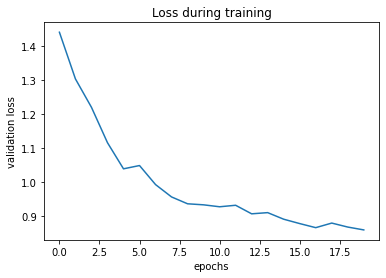

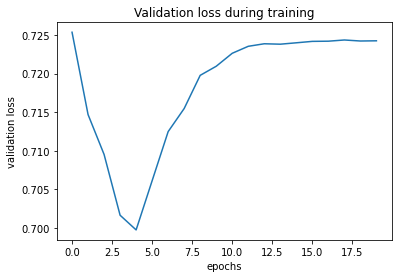

In [28]:
display_helper.show_plot(x = range(len(history['loss'])), y = history['loss'] ,xlabel = "epochs", ylabel = "validation loss", title = "Loss during training")

display_helper.show_plot(x = range(len(history['loss'])), y = history['val_loss'] ,xlabel = "epochs", ylabel = "validation loss", title = "Validation loss during training")


#### Make predictions on test set

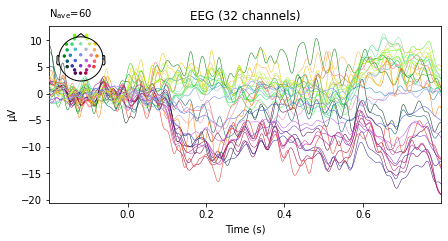

0: female, 1: risk, 0: standard


In [65]:
# Loop over test_set, analyse each file x amount of time

test_experiment = epodium_deep_learning.EvokedDataIterator([testset[0]], path_processed)

index = 16


x, y = test_experiment.__getitem__(0)
info = mne.create_info(epodium.channel_names, 512, ch_types='eeg')
evoked = mne.EvokedArray(x[index], info, tmin=-0.2, nave=60)
montage = mne.channels.make_standard_montage('standard_1020')
evoked.info.set_montage(montage, on_missing = 'ignore')
fig = evoked.plot(spatial_colors = True)

label_sex = 'male' if y[index][0] else 'female'
label_risk = 'risk' if y[index][1] else 'no risk'
label_event = 'deviant' if y[index][2] else 'standard'

print (f"{int(y[index][0])}: {label_sex}, {int(y[index][1])}: {label_risk}, "\
         f"{int(y[index][2])}: {label_event}")

# Load 

In [66]:
## TODO Choose model from all loaded models:

# path_models = glob.glob(os.path.join(local_paths.models, '*' + model_extension))
# models = []
# paths_model_file = []
# paths_model_history = []

# for path_model in path_models:
#     model_temp = os.path.splitext(path_model)[0]    
#     models.append(os.path.basename(model_temp))
#     paths_model_file.append(model_temp + model_extension)
#     paths_model_history.append(model_temp + '_history.npy')

# model = ipywidgets.Select(options=models, description='Models:')
# display(model)